# Get started
In this tutorial we investigate how to solve single-phase flow in PorePy using a two-point flux approximation.<br>
Let is $\Omega$ a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts useful to impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The single-phase flow can be written as
$$ - \nabla \cdot K \nabla p = f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad - K \nabla p \cdot \mathbf{n} = u_b$$

Where $f$ is a scalar source/sink term, $K$ is the permeability matrix, $p_b$ is the pressure at the boundary (Dirichlet condition), and $u_p$ is the flux at the boundary (Neumann condition).<br>

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem. <br><br>

For the example we assume: $\Omega = [0, 1]^2$, $\partial \Omega_d = \partial \Omega$, $\partial \Omega_n = \emptyset$, with data: $f = 1$, $K = I$, and $p_b = 0$.

## Import modules
Before creating the grid we need access to the following PorePy modules and classes:
* `plot_grid` plots the grid and the solution using Matplotlib;
* `tensor` is used to declare the permeability;
* `BoundaryCondition` handles the information useful for the boundary conditions.
* `Parameters` contains the physical data for the problem.

They are all accessed through the `import porepy as pp` statement. We also use the standard python libraries `numpy` and `scipy.sparse`.

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

## Creation of the grid
We create a Cartesian grid and compute its geometry.

In [2]:
Nx = Ny = 10                                         
g = pp.CartGrid([Nx, Ny], [1, 1])
g.compute_geometry()

Represent the grid with additional information: 
* `info='c'` represents cell information, center and id
* `info='f'` represents face information, center and id
* `info='n'` represents node information, position and id
* `info='o'` represents normal information

A combination of the options is possible, the order is not important. <br>

**Note**: The `info='all'` is equivalent to `info='cfno'`

/home/eke001/anaconda3/envs/pp/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


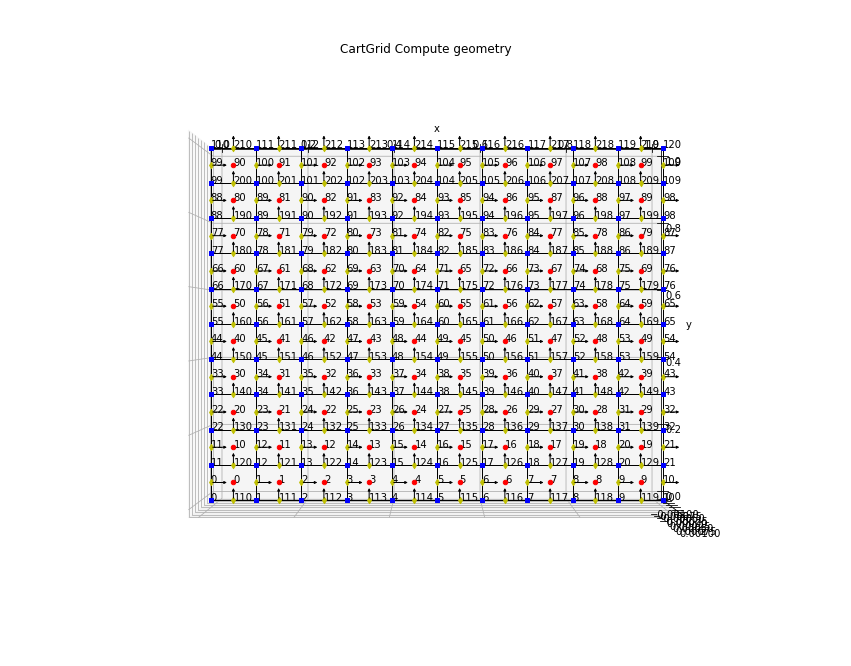

In [3]:
pp.plot_grid(g, info="all", alpha=0, figsize=(15, 12))

# Problem data
All the data in PorePy are piecewise constant in their respective domain (cells or faces).<br>
The simplest way to create an identity tensor is:

In [4]:
perm = pp.SecondOrderTensor(np.ones(g.num_cells))

However, the test case has an heterogeneous permeability tensor $K$ and a constant scalar source term $f$. They can be declared as

In [5]:
Omega_1 = g.cell_centers[0, :] < 0.5

kxx, kyy, kxy = 1e2*np.ones(g.num_cells), np.ones(g.num_cells), 8*np.ones(g.num_cells)
kxx[Omega_1] = np.ones(np.sum(Omega_1))
kyy[Omega_1] = 1e2*np.ones(np.sum(Omega_1))
perm = pp.SecondOrderTensor(kxx=kxx, kyy=kyy, kxy=kxy)                              
f = g.cell_volumes

To impose the boundary conditions we need to create an object of class `BoundaryCondition`. Apart from the grid, it needs the list of the boundary faces and a flag indicating the type of boundary condition:
* `'dir'` for Dirichlet
* `'neu'` for Neumann

The value of the boundary conditions is stored in a vector of lenght `g.num_faces`.<br>
**Note**: The list of face ids needs to be sorted.<br>
**Note**: In the case of mixed boundary conditions only one object is required, the flags need to be ordered according to the second argument of the constructor of `BoundaryCondition`.

In [6]:
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

labels = np.array(['dir']*b_faces.size)
labels[g.face_centers[1, b_faces] == 1.] = 'neu'

bc = pp.BoundaryCondition(g, b_faces, labels)

bc_val = np.zeros(g.num_faces)
bottom = b_faces[g.face_centers[1, b_faces] == 0.]
bc_val[bottom] = np.ones(bottom.size)

Once all the data are created we use the data class to group them. Since we solve a flow problem, we use `'flow'` as key for the problem physics.

In [7]:
specified_parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
data = pp.initialize_default_data(g, {}, "flow", specified_parameters)

## Problem solution
PorePy implements a common interface for all numerical schemes: it returns the matrix and the right-hand side given the grid and problem data. <br>

In [8]:
solver = pp.Tpfa("flow")
solver.discretize(g, data)
A, b = solver.assemble_matrix_rhs(g, data)
p = sps.linalg.spsolve(A, b)

`plot_grid` is able to represent piecewise constant solutions, scalar and vector fields.

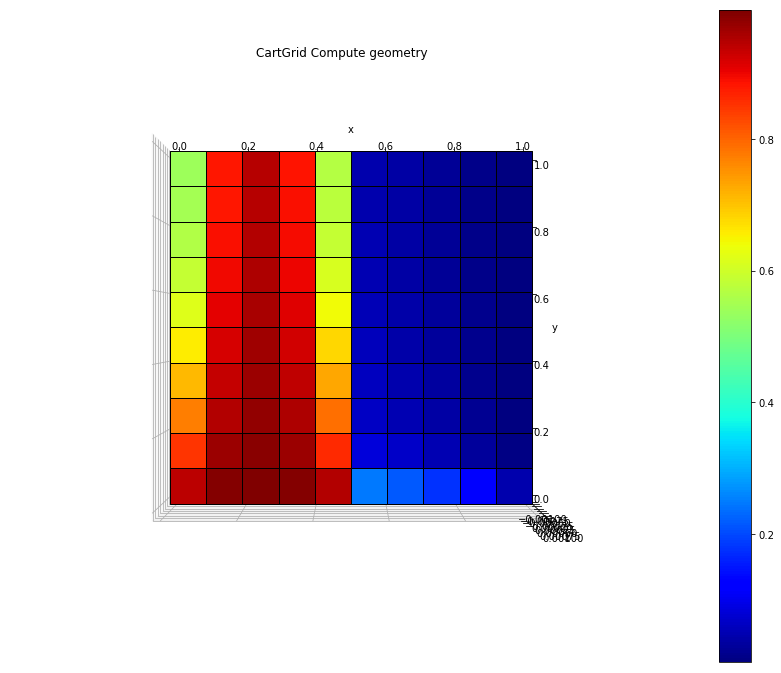

In [9]:
pp.plot_grid(g, p, figsize=(15, 12))

Consistency test with a known solution.

In [10]:
assert np.isclose(pp.error.norm_L2(g, p), 0.6041807238769925)